In [2]:
import numpy as np
dataset = np.load('sdss_galaxy_colors.npy')
dataset
# We don't require 'spec_class' and 'redshift_err' for our purpose, only columns u, g, r, i, z, redshift are of relevance

array([ (19.84132, 19.52656, 19.46946, 19.17955, 19.10763, b'QSO', 0.539301, 6.543622e-05),
       (19.86318, 18.66298, 17.84272, 17.38978, 17.14313, b'GALAXY', 0.1645703, 1.186625e-05),
       (19.97362, 18.31421, 17.47922, 17.0744, 16.76174, b'GALAXY', 0.04190006, 2.183788e-05),
       ...,
       (19.82667, 18.10038, 17.16133, 16.5796, 16.19755, b'GALAXY', 0.0784592, 2.159406e-05),
       (19.98672, 19.75385, 19.5713, 19.27739, 19.25895, b'QSO', 1.567295, 0.0004505933),
       (18.00024, 17.80957, 17.77302, 17.72663, 17.7264, b'QSO', 0.4749449, 6.203324e-05)], 
      dtype=[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('spec_class', 'S6'), ('redshift', '<f8'), ('redshift_err', '<f8')])

In [3]:
# MILESTONE 1: Get FEATURES and TARGET for the dataset

def get_features_targets(dataset):
    features = np.zeros((dataset.shape[0], 4))    # n lines, 4 columns, shape parameter has to be an int or sequence of int
    features[:, 0] = dataset['u'] - dataset['g']
    features[:, 1] = dataset['g'] - dataset['r']
    features[:, 2] = dataset['r'] - dataset['i']
    features[:, 3] = dataset['i'] - dataset['z']
    
    targets = dataset['redshift']
    
    return (features, targets)

features, targets = get_features_targets(dataset)
print(features[:5])
print(targets[:5])

[[ 0.31476  0.0571   0.28991  0.07192]
 [ 1.2002   0.82026  0.45294  0.24665]
 [ 1.65941  0.83499  0.40482  0.31266]
 [ 1.5653   0.90174  0.49873  0.38671]
 [ 1.12483  0.65899  0.36996  0.16539]]
[ 0.539301    0.1645703   0.04190006  0.04427702  0.04164413]


In [4]:
# MILESTONE 2: (i) Create a model (ii) Train it (iii) Get some predictions

from sklearn.tree import DecisionTreeRegressor

# Initialise the model
dtr = DecisionTreeRegressor()

# Train the model
dtr.fit(features, targets)

# Make predictions using same features
predictions = dtr.predict(features)

# Print out the first 4 predictions
print(predictions[:4])

[ 0.539301    0.1645703   0.04190006  0.04427702]


In [8]:
# MILESTONE 3: Using the approach of held-out validation to validate our model (Will use k-fold cross validation later)
# Function to calculate the median of differences between our predicted and actual values
def median_diff(predicted, actual):
    diff = np.median(np.absolute(predicted - actual))
    return diff

# Function to split the dataset into training and testing features and predictions
# This will train the model and return prediction accuracy with median_diff
def validate_model(model, features, targets):
    split = features.shape[0]//2     # Discard remainder
    train_features = features[:split]
    test_features = features[split:]
    
    train_targets = targets[:split]
    test_targets = targets[split:]
    
    # Train the model
    model.fit(train_features, train_targets)
    
    # Obtain predicted redshifts
    predictions = model.predict(test_features)
    
    # Using median_diff to calculate accuracy
    return median_diff(test_targets, predictions)

dataset = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(dataset)

# Initialising the model
dtr = DecisionTreeRegressor()

# Validating model and printing median_diff
med_diff = validate_model(dtr, features, targets)
print('Median difference: {:f}'.format(med_diff))

Median difference: 0.021987


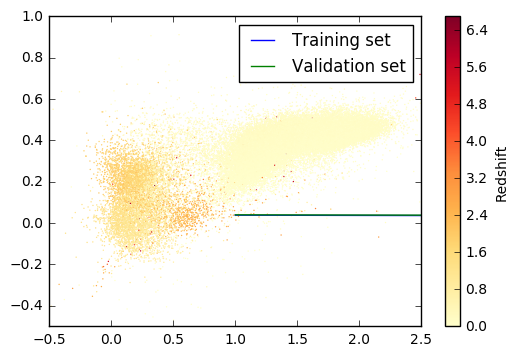

In [24]:
# MILESTONE 4: Plot a colour-index v/s colour-index plot using an additional colour scale to show redshift.
# The obtained graph shows that we get reasonably well-defined regions where redshifts are similar.

from matplotlib import pyplot as plt

dataset = np.load('sdss_galaxy_colors.npy')
# Get a colour map
cmap_ = plt.get_cmap('YlOrRd')

# Define colour indices u-g and r-i
cidx_ug = dataset['u'] - dataset['g']
cidx_ri = dataset['r'] - dataset['i']

# Initialise redshift array
redshift = dataset['redshift']

# Create a plot
plt.scatter(cidx_ug, cidx_ri, c = redshift, lw = 0, s = 1, cmap = cmap_)
colorbar = plt.colorbar().set_label("Redshift")

# Define axes labels and plot title
plt.xlabel = "Colour index u-g"
plt.ylabel = "Colour index r-i"
plt.title = "Redshift (colour) u-g v/s r-i"

plt.axis([-0.5, 2.5, -0.5, 1])
plt.legend()
plt.show()



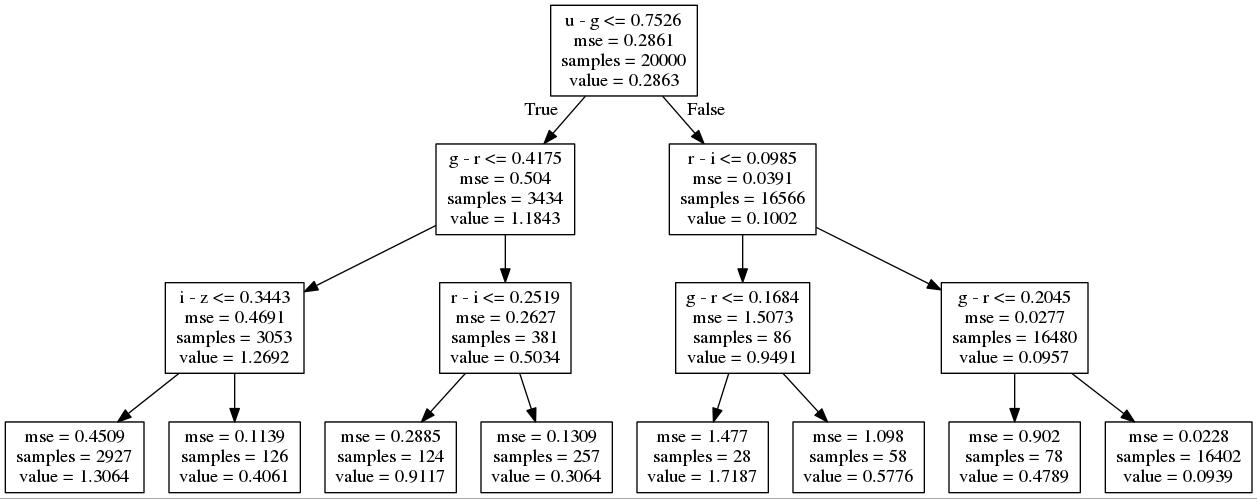

In [11]:
from IPython.display import Image
Image("decision_tree.jpg")

Depth with lowest median difference : 19


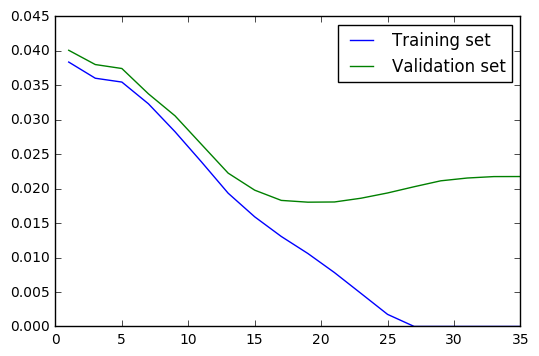

In [25]:
# MILESTONE 5: Cross validate the model, checking how overfitting the Decision Tree model is

def accuracy_by_treedepth(features, targets, depths):
    # split the data into testing and training sets
    split = features.shape[0]//2
    
    train_features = features[:split]
    test_features = features[split:]
    train_targets = targets[:split]
    test_targets = targets[split:]

    # initialise arrays or lists to store the accuracies for the below loop
    mediandiffs_training = []
    mediandiffs_test = []
  
    # loop through depths
    for depth in depths:
        # initialize model with the maximum depth. 
        dtr = DecisionTreeRegressor(max_depth=depth)

        # train the model using the training set
        dtr.fit(train_features, train_targets)

        # get the predictions for the training set and calculate their median_diff
        predictions = dtr.predict(train_features)
        accuracy = median_diff(train_targets, predictions)
        mediandiffs_training.append(accuracy)

        # get the predictions for the testing set and calculate their median_diff
        predictions = dtr.predict(test_features)
        accuracy = median_diff(test_targets, predictions)
        mediandiffs_test.append(accuracy)
    
    # return the accuracies for the training and testing sets
    return (mediandiffs_training, mediandiffs_test)

dataset = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(dataset)

# Generate several depths to test
tree_depths = [i for i in range(1, 36, 2)]

# Call the function
train_med_diffs, test_med_diffs = accuracy_by_treedepth(features, targets, tree_depths)
print("Depth with lowest median difference : {}".format(tree_depths[test_med_diffs.index(min(test_med_diffs))]))
    
# Plotting the results
train_plot = plt.plot(tree_depths, train_med_diffs, label='Training set')
test_plot = plt.plot(tree_depths, test_med_diffs, label='Validation set')
plt.xlabel = "Maximum Tree Depth"
plt.ylabel = "Median of Differences"
plt.legend()
plt.show()

# OBSERVATIONS: 
# Accuracy of decision tree on training set gets better as we allow the tree to get to greater depths.
# Conversely, accuracy measure  of the predictions for the test set gets better initially and worse at larger tree depths. 
# At a tree depth ~19 the decision tree starts to overfit the data. 
# This means it tries to take into account outliers in the training set and loses its general predictive accuracy. 

In [38]:
# MILESTONE 6: Use the method of K-fold cross validation

from sklearn.model_selection import KFold

def cross_validate_model(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)

    # Initialising a list to collect median_diffs for each iteration of the loop below
    mediandiffs = []
  
    for train_indices, test_indices in kf.split(features):
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]

        # Fitting the model for the current set
        model.fit(train_features, train_targets)

        # Predicting using the model
        predictions = model.predict(test_features)

        # Calculating the median_diff from predicted values and append to results array
        mediandiffs.append(median_diff(test_targets, predictions))
 
    # Return the list with median difference values
    return mediandiffs

dataset = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(data)

# Initialize model with a maximum depth of 19
dtr = DecisionTreeRegressor(max_depth=19)

# Calling cross validation function
diffs = cross_validate_model(dtr, features, targets, 10)

print('Differences: {}'.format(', '.join(['{:.3f}'.format(val) for val in diffs])))
print('Mean difference: {:.3f}'.format(np.mean(diffs)))



ImportError: cannot import name '_safe_split'

In [39]:
def cross_validate_predictions(model, features, targets, k):
    kf = KFold(n_splits=k, shuffle=True)

    # declare an array for predicted redshifts from each iteration
    all_predictions = np.zeros_like(targets)

    for train_indices, test_indices in kf.split(features):
        print (train_indices, len(train_indices), test_indices, len(test_indices))
        # split the data into training and testing
        train_features, test_features = features[train_indices], features[test_indices]
        train_targets, test_targets = targets[train_indices], targets[test_indices]

        # fit the model for the current set
        model.fit(train_features, train_targets)

        # predict using the model
        predictions = model.predict(test_features)

        # put the predicted values in the all_predictions array defined above
        all_predictions[test_indices] = predictions

    return all_predictions    

dataset = np.load('sdss_galaxy_colors.npy')
features, targets = get_features_targets(dataset)

# initialize model
dtr = DecisionTreeRegressor(max_depth=19)

# Call cross validation function
predictions = cross_validate_predictions(dtr, features, targets, 10)

# calculate and print the rmsd as a sanity check
diffs = median_diff(predictions, targets)
print('Median difference: {:.3f}'.format(diffs))

# plot the results to see how well our model looks
plt.scatter(targets, predictions, s=0.4)
plt.xlim((0, targets.max()))
plt.ylim((0, predictions.max()))
plt.xlabel('Measured Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

NameError: name 'KFold' is not defined

In [32]:
# MILESTONE 7: Check out whether there is a difference in the accuracy of the decision trees between QSOs 
# and regular galaxies. 

# The sample of galaxies we dealt with consists of two types of population: Regular galaxies and Quasi Stellar Objects(QSO)
# QSOs are a type of galaxy that contain an actively (and intensly) accreting supermassive black hole. 
# This is often referred to as an Active Galactic Nucleus (AGN). 
# The light emitted from the AGN is significantly brighter than the rest of the galaxy 
# and we are able to detect these QSOs out to much higher redshifts.
#  Due to this contribution from the AGN, the flux magnitudes measured at different wavelengths might not follow 
# the typical profile we assumed when predicting redshifts. 

def split_galaxies_qsos(data):
    galaxies = data[data['spec_class'] == b'GALAXY']
    qsos = data[data['spec_class'] == b'QSO']
    return (galaxies, qsos)

def cross_validate_median_diff(data):
    features, targets = get_features_targets(data)
    dtr = DecisionTreeRegressor(max_depth=19)
    return np.mean(cross_validate_model(dtr, features, targets, 10))

dataset = np.load('sdss_galaxy_colors.npy')
galaxies, qsos= split_galaxies_qsos(dataset)

# Here we cross validate the model and get the cross-validated median difference
# The cross_validated_med_diff function is in "written_functions"
galaxy_med_diff = cross_validate_median_diff(galaxies)
qso_med_diff = cross_validate_median_diff(qsos)

# Print the results
print("Median difference for Galaxies: {:.3f}".format(galaxy_med_diff))
print("Median difference for QSOs: {:.3f}".format(qso_med_diff))


NameError: name 'cross_validate_model' is not defined

In [37]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.17.1.
